# Fresh take at HMM's with JAX...



In [1]:
import jax.numpy as np
import jax.random as jr
import jax.scipy.special as spsp
from jax import lax, value_and_grad, jit, vmap, grad
from jax.tree_util import register_pytree_node, register_pytree_node_class
from tensorflow_probability.python.internal import reparameterization
from tensorflow_probability.substrates import jax as tfp


from functools import partial, wraps
from textwrap import dedent
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm.auto import trange
from enum import IntEnum
import warnings


# SSM interface 

All state space models have:
- `initial_state_dist`
- `dynamics_dist`
- `emissions_dist`

In [2]:
class SSM(object):

    def initial_state_dist(self):
        raise NotImplementedError

    def dynamics_dist(self, state):
        raise NotImplementedError

    def emissions_dist(self, state):
        raise NotImplementedError

    def log_probability(self, states, data):
        """
        Compute the log joint probability of a set of states and data
        """
        lp = 0 
        lp += self.initial_state_dist().log_prob(states[0])
        lp += self.emissions_dist(states[0]).log_prob(data[0])

        def _step(carry, args):
            prev_state, lp = carry
            state, emission = args
            lp += self.dynamics_dist(prev_state).log_prob(state)
            lp += self.emissions_dist(state).log_prob(emission)
            return (state, lp), None

        (_, lp), _ = lax.scan(_step, (states[0], lp), zip(states[1:], data[1:]))

    def sample(self, key, num_steps, covariates=None, initial_state=None):
        """
        Sample the state space model for specified number of steps.
        """
        with warnings.catch_warnings():
          warnings.simplefilter("ignore", UserWarning)
          if initial_state is None:
              key1, key = jr.split(key, 2)
              initial_state = self.initial_state_dist().sample(seed=key1)

          def _step(state, key):
              key1, key2 = jr.split(key, 2)
              emission = self.emissions_dist(state).sample(seed=key1)
              next_state = self.dynamics_dist(state).sample(seed=key2)
              return next_state, (state, emission)

          keys = jr.split(key, num_steps)
          _, (states, emissions) = lax.scan(_step, initial_state, keys)

          return states, emissions

## HMM is a special case of SSM

In [3]:
class _StandardHMM(SSM):
    
    def __init__(self, num_states,
                 initial_state_probs=None,
                 initial_state_logits=None,
                 initial_state_prior_concentration=1.1,
                 transition_matrix=None,
                 transition_logits=None,
                 transition_prior_concentration=1.1):
        """ TODO
        """
        self.num_states = num_states

        # Set up the initial state distribution and prior
        if initial_state_probs is None and initial_state_logits is None:
            initial_state_logits = np.zeros(num_states)
        self._initial_state_dist = tfp.distributions.Categorical(logits=initial_state_logits,
                                                                 probs=initial_state_probs)
        
        self._initial_state_prior = tfp.distributions.Dirichlet(
            initial_state_prior_concentration * np.ones(num_states))

        # Set up the transition matrix and prior
        if transition_matrix is None and transition_logits is None:
            transition_logits = np.zeros((num_states, num_states))
        self._dynamics_dist = tfp.distributions.Categorical(logits=transition_logits,
                                                            probs=transition_matrix)
        
        self._dynamics_prior = tfp.distributions.Dirichlet(
            transition_prior_concentration * np.ones((num_states, num_states)))
        
    def initial_state_dist(self):
        return self._initial_state_dist

    def dynamics_dist(self, state):
        return self._dynamics_dist[state]

    @property
    def initial_state_probs(self):
        return self._initial_state_dist.probs_parameter()

    @property
    def transition_matrix(self):
        return self._dynamics_dist.probs_parameter()


## GaussianHMM is a special case of HMM

In [4]:
@register_pytree_node_class
class GaussianHMM(_StandardHMM):

    def __init__(self, num_states, emission_dim,
                 initial_state_probs=None,
                 initial_state_logits=None,
                 transition_matrix=None,
                 transition_logits=None,
                 emission_means=None,
                 emission_covariances=None,
                 emission_scale_trils=None):
        """
        """
        _StandardHMM.__init__(self, num_states,
                              initial_state_probs=initial_state_probs,
                              initial_state_logits=initial_state_logits,
                              transition_matrix=transition_matrix,
                              transition_logits=transition_logits)
        
        # Initialize the Gaussian emissions
        self.emission_dim = emission_dim

        if emission_means is None:
            emission_means = np.zeros((num_states, emission_dim))

        if emission_scale_trils is None:
            if emission_covariances is None:
                emission_scale_trils = np.tile(np.eye(emission_dim), (num_states, 1, 1))
            else:
                emission_scale_trils = np.linalg.cholesky(emission_covariances)
        
        self._emissions_dist = tfp.distributions.MultivariateNormalTriL(loc=emission_means,
                                                                        scale_tril=emission_scale_trils)

    def emissions_dist(self, state):
        return self._emissions_dist[state]

    @property
    def emission_means(self):
        return self._emissions_dist.mean()

    @property
    def emission_covariances(self):
        return self._emissions_dist.covariance()

    @classmethod
    def initialize(cls, rng, num_states, data):
        # Pick random data points as the means
        num_timesteps, emission_dim = data.shape
        inds = jr.choice(rng, num_timesteps, shape=(num_states,), replace=False)
        means = data[inds]
        
        # Set the covariance to a fraction of the marginal covariance
        cov = np.cov(data, rowvar=False)
        scale_tril = np.tile(np.linalg.cholesky(cov) / num_states, (num_states, 1, 1))

        return cls(num_states, emission_dim, 
                   emission_means=means, 
                   emission_scale_trils=scale_tril)

    # Note: using tree_flatten and tree_unflatten for two purposes:
    # 1. Make GaussianHMM a PyTree (and hence jittable)
    # 2. Get the unconstrained parameters of the model
    def tree_flatten(self):
        children = (self._initial_state_dist.logits_parameter(),
                    self._dynamics_dist.logits_parameter(),
                    self._emissions_dist.loc,
                    self._emissions_dist.scale_tril)
        aux_data = self.num_states, self.emission_dim
        return children, aux_data
        
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        num_states, emission_dim = aux_data
        initial_state_logits, transition_logits, emission_means, emission_scale_trils = children

        # Construct a new HMM
        return cls(num_states, emission_dim,
                   initial_state_logits=initial_state_logits,
                   transition_logits=transition_logits,
                   emission_means=emission_means,
                   emission_scale_trils=emission_scale_trils)
        
    def tree_unflatten_inplace(self, aux_data, children):
        num_states, emission_dim = aux_data
        initial_state_logits, transition_logits, emission_means, emission_scale_trils = children

        self.__init__(num_states, emission_dim,
                      initial_state_logits=initial_state_logits,
                      transition_logits=transition_logits,
                      emission_means=emission_means,
                      emission_scale_trils=emission_scale_trils)
        

In [5]:
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2))
true_hmm = GaussianHMM(3, 2,
                       transition_matrix=transition_matrix,
                       emission_means=emission_means,
                       emission_scale_trils=0.25 * np.eye(2))
states, data = true_hmm.sample(jr.PRNGKey(0), 1000)

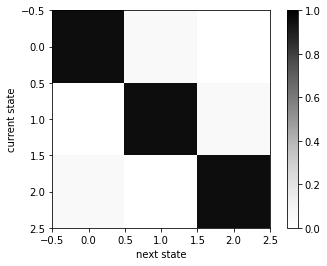

In [6]:
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.colorbar()

Text(0, 0.5, 'observation')

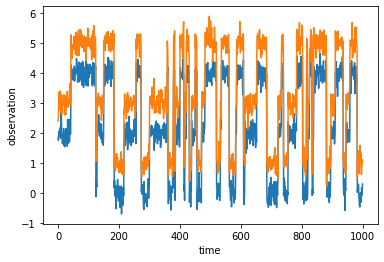

In [7]:
plt.plot(data)
plt.xlabel("time")
plt.ylabel("observation")

Test that we can jit compile functions of these objects.


In [8]:
@jit
def test(hmm):
    hmm._emissions_dist = tfp.distributions.MultivariateNormalTriL(
        hmm._emissions_dist.loc + 3, hmm._emissions_dist.scale)
    return hmm

out = test(true_hmm)
out._emissions_dist.loc 
out._initial_state_dist.logits_parameter()

DeviceArray([0., 0., 0.], dtype=float32)

## PoissonHMM is a special case of HMM

In [9]:
@register_pytree_node_class
class PoissonHMM(_StandardHMM):

    def __init__(self, num_states, emission_dim,
                 initial_state_probs=None,
                 initial_state_logits=None,
                 transition_matrix=None,
                 transition_logits=None,
                 emission_rates=None,
                 emission_log_rates=None):
        """
        """
        _StandardHMM.__init__(self, num_states,
                              initial_state_probs=initial_state_probs,
                              initial_state_logits=initial_state_logits,
                              transition_matrix=transition_matrix,
                              transition_logits=transition_logits)
        
        # Initialize the Gaussian emissions
        self.emission_dim = emission_dim

        if emission_log_rates is None:
            if emission_rates is None:
                emission_log_rates = np.zeros((num_states, emission_dim))
            else:
                emission_log_rates = np.log(emission_rates)
            
        self._emissions_dist = tfp.distributions.Independent(
            tfp.distributions.Poisson(log_rate=emission_log_rates),
            reinterpreted_batch_ndims=1)

    def emissions_dist(self, state):
        return self._emissions_dist[state]

    @property
    def emission_rates(self):
        return self._emissions_dist.mean()

    @classmethod
    def initialize(cls, rng, num_states, data):
        # Pick random data points as the means
        num_timesteps, emission_dim = data.shape
        assignments = jr.choice(rng, num_states, shape=(num_timesteps,))
        rates = np.row_stack([data[assignments == k].mean(axis=0) for k in range(num_states)])
        
        return cls(num_states, emission_dim, 
                   emission_rates=rates)

    # Note: using tree_flatten and tree_unflatten for two purposes:
    # 1. Make GaussianHMM a PyTree (and hence jittable)
    # 2. Get the unconstrained parameters of the model
    def tree_flatten(self):
        children = (self._initial_state_dist.logits_parameter(),
                    self._dynamics_dist.logits_parameter(),
                    self._emissions_dist.distribution.log_rate_parameter())
        aux_data = self.num_states, self.emission_dim
        return children, aux_data
        
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        num_states, emission_dim = aux_data
        initial_state_logits, transition_logits, emission_log_rates = children

        # Construct a new HMM
        return cls(num_states, emission_dim,
                   initial_state_logits=initial_state_logits,
                   transition_logits=transition_logits,
                   emission_log_rates=emission_log_rates)
        
    def tree_unflatten_inplace(self, aux_data, children):
        num_states, emission_dim = aux_data
        initial_state_logits, transition_logits, emission_log_rates = children

        # Construct a new HMM
        self.__init__(num_states, emission_dim,
                      initial_state_logits=initial_state_logits,
                      transition_logits=transition_logits,
                      emission_log_rates=emission_log_rates)
        

Text(0, 0.5, 'neuron')

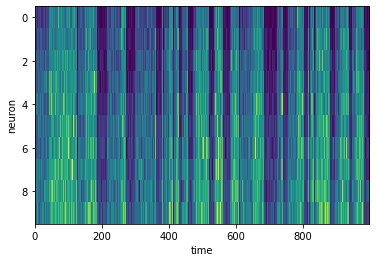

In [10]:
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_rates = np.arange(1, 31, dtype=np.float32).reshape((3, 10))
poisson_hmm = PoissonHMM(3, 10,
                         transition_matrix=transition_matrix,
                         emission_rates=emission_rates)
states, data = poisson_hmm.sample(jr.PRNGKey(0), 1000)

plt.imshow(data.T, aspect="auto", interpolation="none")
plt.xlabel("time")
plt.ylabel("neuron")

In [11]:
# Test that we can jit-compile a PoissonHMM
# @jit
# def test(hmm):
#     hmm._emissions_dist = \
#         tfp.distributions.Independent(
#             tfp.distributions.Poisson(
#                 hmm._emissions_dist.distribution.mean() + 3),
#             1)
#     return hmm

# transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
# emission_rates = np.arange(1, 31, dtype=np.float32).reshape((3, 10))

# poisson_hmm = PoissonHMM(3, 10,
#                          transition_matrix=transition_matrix,
#                          emission_rates=emission_rates)

# poisson_hmm2 = test(poisson_hmm)
# poisson_hmm2.emission_rates

# Core message passing code

A function for message passing in a discrete chain graph (i.e. HMM)

In [12]:
def hmm_log_normalizer(log_initial_state_probs,
                       log_transition_matrix,
                       log_likelihoods):
    """Compute the marginal likelihood (i.e. log normalizer) under
    a Hidden Markov Model (HMM) with the specified natural parameters.
    The normalizer is computed via the forward message passing recursion,
        \log \alpha_{t+1,j} =
            \log \sum_i \exp \{ \log \alpha_{t,i} +
                                \log p(x_t | z_t = i) +
                                \log p(z_{t+1} = j | z_t = i) \}
    where
        \alpha_{t+1} \propto p(z_{t+1} | x_{1:t}).

    Args:
        log_initial_state_probs: Log of the initial state probabilities.
            A shape ``(K,)`` array where ``K`` is the number of states.

        log_transition_matrix: Log transition matrix or matrices. The shape
            must either be ``(K, K)`` where ``K`` is the number of states
            or ``(T-1, K, K)`` where ``T`` is the length of the sequence.
            In the former case, the entry ``[i,j]`` specifies the log
            probability of transitioning from state ``i`` to state ``j``.
            In the latter case, the ``[t,i,j]`` entry gives the log probability
            of transitioning from state ``z_t = i`` to state ``z_{t+1} = j``
            for ``t=1,...,T-1``.

        log_likelihoods: Log likelihoods combined in a shape ``(T, K)``
            array where ``T`` is the length of the sequence and ``K`` is
            the number of states.  The ``[t, i]`` entry specifies the log
            likelihood of observation ``x[t]`` given state ``z[t] = i``.

    Returns:
        The log probability of the sequence, summing out the discrete states.
    """
    assert log_initial_state_probs.ndim == 1 and log_likelihoods.ndim == 2
    num_states = len(log_initial_state_probs)
    num_timesteps = len(log_likelihoods)
    assert log_likelihoods.shape[1] == num_states

    if log_transition_matrix.ndim == 2:
        # Stationary (fixed) transition probabilities
        assert log_transition_matrix.shape == (num_states, num_states)
        return _stationary_hmm_log_normalizer(log_initial_state_probs,
                                              log_transition_matrix,
                                              log_likelihoods)

    elif log_transition_matrix.ndim == 3:
        # Time-varying transition probabilities
        assert log_transition_matrix.shape == \
            (num_timesteps - 1, num_states, num_states)
        return _nonstationary_hmm_log_normalizer(log_initial_state_probs,
                                                 log_transition_matrix,
                                                 log_likelihoods)

    else:
        raise Exception("`log_transition_matrix` must be either 2d or 3d.")


def _stationary_hmm_log_normalizer(log_initial_state_probs,
                                   log_transition_matrix,
                                   log_likelihoods):
    def marginalize(alpha, ll):
        alpha = spsp.logsumexp(alpha + ll + log_transition_matrix.T, axis=1)
        return alpha, alpha

    alpha_T, alphas = lax.scan(marginalize,
                               log_initial_state_probs,
                               log_likelihoods[:-1])

    # Note: alphas is interesting too, for forward filtering
    # Could return ..., np.row_stack((log_initial_state_probs, alphas))

    # Account for the last timestep when computing marginal lkhd
    return spsp.logsumexp(alpha_T + log_likelihoods[-1])


def _nonstationary_hmm_log_normalizer(log_initial_state_probs,
                                      log_transition_matrices,
                                      log_likelihoods):
    def marginalize(alpha, prms):
        log_P, ll = prms
        alpha = spsp.logsumexp(alpha + ll + log_P.T, axis=1)
        return alpha, alpha

    alpha_T, alphas = lax.scan(marginalize,
                               log_initial_state_probs,
                               (log_transition_matrices, log_likelihoods[:-1]))

    # Account for the last timestep when computing marginal lkhd
    return spsp.logsumexp(alpha_T + log_likelihoods[-1])

hmm_expected_states = jit(value_and_grad(hmm_log_normalizer, argnums=(0,1,2)))

In [13]:
# # Test
# log_initial_state_distn = hmm.initial_state_dist().logits_parameter()
# log_transition_matrix = np.log(hmm.transition_matrix)
# # log_likelihoods = vmap(hmm._emissions_dist.log_prob)(data)  # hacky ref to _emissions_dist
# # log_likelihoods = vmap(lambda k: hmm.emissions_dist(k).log_prob(data))(np.arange(hmm.num_states)).T
# log_likelihoods = vmap(lambda k: 
#                        vmap(lambda x: hmm.emissions_dist(k).log_prob(x))(data)
#                        )(np.arange(hmm.num_states)).T
# log_likelihoods.shape

# out = hmm_expected_states(log_initial_state_distn,
#                     log_transition_matrix,
#                     log_likelihoods)

# Exponential family set up

Adapted from JXF

## Normal inverse Wishart / Multivariate Normal

In [14]:
class NormalInverseWishart(tfp.distributions.Distribution):
    def __init__(self, 
                 loc, 
                 mean_precision, 
                 df, 
                 scale,
                 validate_args=False,
                 allow_nan_stats=True,
                 name="NormalInverseWishart"):
        
        self.loc = loc
        self.mean_precision = mean_precision
        self.df = df
        self.scale = scale

        super(NormalInverseWishart, self).__init__(
          dtype=loc.dtype,
          validate_args=validate_args,
          allow_nan_stats=allow_nan_stats,
          reparameterization_type=reparameterization.NOT_REPARAMETERIZED,
          parameters=dict(locals()),
          name=name)

    @property
    def dim(self):
        return self.loc.shape[-1]

    def _log_prob(self, data):
        """Compute the prior log probability of a MultivariateNormal
        distribution's parameters under this NIW prior.
        Note that the NIW prior is only properly specified in certain
        parameter regimes (otherwise the density does not normalize).
        Only compute the log prior if there is a density.
        """
        mu, Sigma = data
        
        lp = 0
        
        if self.df >= self.dim:
            # TODO: get rid of all the inverses
            wish = tfp.distributions.WishartTriL(self.df, np.linalg.cholesky(np.linalg.inv(self.scale)))
            lp += wish.log_prob(np.linalg.inv(Sigma))

        if self.mean_precision > 0:
            mvn = tfp.distributions.MultivariateNormalFullCovariance(self.loc, covariance_matrix / self.mean_precision)
            lp += mvn.log_prob(mu)

        return lp

    def _mode(self):
        r"""Solve for the mode. Recall,
        .. math::
            p(\mu, \Sigma) \propto
                \mathrm{N}(\mu | \mu_0, \Sigma / \kappa_0) \times
                \mathrm{IW}(\Sigma | \nu_0, \Psi_0)
        The optimal mean is :math:`\mu^* = \mu_0`. Substituting this in,
        .. math::
            p(\mu^*, \Sigma) \propto IW(\Sigma | \nu_0 + 1, \Psi_0)
        and the mode of this inverse Wishart distribution is at
        .. math::
            \Sigma^* = \Psi_0 / (\nu_0 + d + 2)
        """
        covariance = np.einsum('...,...ij->...ij', 1 / (self.df + self.dim + 2), self.scale)
        return self.loc, covariance


In [15]:
# Normal inverse Wishart prior 
def _niw_from_stats(stats, counts):
    s_1, s_2, s_3 = stats
    dim = s_2.shape[-1]

    mean_precision = s_1
    # loc = lax.cond(mean_precision > 0,
    #             lambda x: s_2 / mean_precision,
    #             lambda x: np.zeros_like(s_2),
    #             None)
    loc = np.einsum('...i,...->...i', s_2, 1 / mean_precision)
    scale = s_3 - np.einsum('...,...i,...j->...ij', mean_precision, loc, loc)
    df = counts - dim - 2
    return NormalInverseWishart(loc, mean_precision, df, scale)

def _niw_pseudo_obs_and_counts(niw):
    pseudo_obs = (
        niw.mean_precision,
        niw.mean_precision * niw.loc,
        niw.scale + niw.mean_precision * np.einsum('...i,...j->...ij', niw.loc, niw.loc))
    
    pseudo_counts = niw.df + niw.dim + 1
    return pseudo_obs, pseudo_counts


# Multivariate normal likelihood
def _mvn_from_params(params):
    loc, covariance = params
    scale_tril = np.linalg.cholesky(covariance)
    return tfp.distributions.MultivariateNormalTriL(loc, scale_tril)

def _mvn_suff_stats(data):
    return (np.ones(data.shape[:-1]),
            data,
            np.einsum('...i,...j->...ij', data, data))

# ss = tuple(s.sum(axis=0) for s in _mvn_suff_stats(data))
# niw = _niw_from_stats(ss, len(data))
# niw.mode()

## Gamma / Poisson

In [16]:
def _gamma_from_stats(stats, counts):
    alpha, = stats
    return tfp.distributions.Gamma(alpha, rate=counts[:, None])

def _gamma_pseudo_obs_and_counts(gamma):
    return (gamma.concentration,), gamma.rate

def _poisson_from_params(params):
    return tfp.distributions.Independent(
        tfp.distributions.Poisson(rate=params),
        reinterpreted_batch_ndims=1)

def _poisson_suff_stats(data):
    return (data,)

## Dirichlet / Categorical

In [17]:
def _dirichlet_from_stats(stats, counts):
    concentration = stats[0]
    return tfp.distributions.Dirichlet(concentration)

def _dirichlet_pseudo_obs_and_counts(dirichlet):
    return (dirichlet.concentration,), 0

def _categorical_from_params(params):
    return tfp.distributions.Categorical(probs=params)

def _categorical_suff_stats(data):
    num_classes = int(data.max()) + 1
    return (data[..., None] == np.arange(num_classes),)

## Make a global registry of exponential families

In [18]:
# Register the prior and likelihood functions
ExponentialFamily = namedtuple("ExponentialFamily", 
                               ["prior_pseudo_obs_and_counts", 
                                "posterior_from_stats", 
                                "from_params", 
                                "suff_stats"])

EXPFAM_DISTRIBUTIONS = dict()
EXPFAM_DISTRIBUTIONS["MultivariateNormalTriL"] = \
    ExponentialFamily(_niw_pseudo_obs_and_counts, 
                      _niw_from_stats,
                      _mvn_from_params, 
                      _mvn_suff_stats)
    
EXPFAM_DISTRIBUTIONS["IndependentPoisson"] = \
    ExponentialFamily(_gamma_pseudo_obs_and_counts, 
                      _gamma_from_stats,
                      _poisson_from_params, 
                      _poisson_suff_stats)
    
EXPFAM_DISTRIBUTIONS["Categorical"] = \
    ExponentialFamily(_dirichlet_pseudo_obs_and_counts, 
                      _dirichlet_from_stats,
                      _categorical_from_params, 
                      _categorical_suff_stats)

# Parameter estimation for (exponential family) HMMs

Three ways to fit parameters of an HMM

1. Directly maximize the marginal likelihood with gradient ascent
\begin{align}
\log p(x_{1:T}; \theta) = \log \sum_{z_{1:T}} p(x_{1:T}, z_{1:T}; \theta)
\end{align}
This is the output of the `hmm_log_normalizer` function. Take its gradient and optimize. 

2. Lower bound the marginal likelihood and optimize that. First, find a posterior distribution $q(z_{1:T})$,
\begin{align}
\mathcal{L}(\theta) = \mathbb{E}_{q(z_{1:T})} [\log p(x_{1:T}, z_{1:T}; \theta) - \log q(z_{1:T})]
\end{align}
Then optimize $\mathcal{L}(\theta)$ with gradient ascent

3. Lower bound the marginal likelihood and optimize that. First, find a posterior distribution $q(z_{1:T})$,
\begin{align}
\mathcal{L}(\theta) = \mathbb{E}_{q(z_{1:T})} [\log p(x_{1:T}, z_{1:T}; \theta) - \log q(z_{1:T})]
\end{align}
Solve for $\theta^* =\mathrm{argmax} \mathcal{L}(\theta)$ analytically.



In [19]:
HMMPosterior = namedtuple("HMMPosterior", ["marginal_likelihood", "expected_states", "expected_transitions"])

def sum_tuples(a, b):
    assert a or b
    if a is None:
        return b
    elif b is None:
        return a
    else:
        return tuple(ai + bi for ai, bi in zip(a, b))

def _e_step(hmm, data):
    log_initial_state_distn = hmm.initial_state_dist().logits_parameter()
    log_transition_matrix = np.log(hmm.transition_matrix)
    log_likelihoods = vmap(lambda k: 
                            vmap(lambda x: hmm.emissions_dist(k).log_prob(x))(data)
                            )(np.arange(hmm.num_states)).T

    marginal_likelihood, (Ez0, Ezzp1, Ez) = \
        hmm_expected_states(log_initial_state_distn,
                            log_transition_matrix,
                            log_likelihoods)
        
    return HMMPosterior(marginal_likelihood, Ez, Ezzp1)

def _exact_m_step_initial_state_dist(hmm, data, posterior):
    expfam = EXPFAM_DISTRIBUTIONS["Categorical"]
    prior_stats, prior_counts = expfam.prior_pseudo_obs_and_counts(hmm._initial_state_prior)
    lkhd_stats, lkhd_counts = (posterior.expected_states[0],), 0
    param_posterior = expfam.posterior_from_stats(
        sum_tuples(prior_stats, lkhd_stats),
        prior_counts + lkhd_counts)
    hmm._initial_state_dist = expfam.from_params(param_posterior.mode())

def _exact_m_step_dynamics_dist(hmm, data, posterior):
    expfam = EXPFAM_DISTRIBUTIONS["Categorical"]
    prior_stats, prior_counts = expfam.prior_pseudo_obs_and_counts(hmm._dynamics_prior)
    lkhd_stats, lkhd_counts = (posterior.expected_transitions,), 0
    param_posterior = expfam.posterior_from_stats(
        sum_tuples(prior_stats, lkhd_stats),
        prior_counts + lkhd_counts)
    hmm._dynamics_dist = expfam.from_params(param_posterior.mode())

def _exact_m_step_emissions_dist(hmm, data, posterior):
    # Use exponential family stuff for the emissions
    expfam = EXPFAM_DISTRIBUTIONS[hmm._emissions_dist.name]
    
    # TODO: incorporate prior

    # Compute sufficient statistics of the data
    stats = expfam.suff_stats(data)
    weighted_stats = tuple(np.einsum('tk,t...->k...', posterior.expected_states, s) for s in stats)
    counts = np.sum(posterior.expected_states, axis=0)

    param_posterior = expfam.posterior_from_stats(weighted_stats, counts)
    hmm._emissions_dist = expfam.from_params(param_posterior.mode())

def _exact_m_step(hmm, data, posterior):
    _exact_m_step_initial_state_dist(hmm, data, posterior)
    _exact_m_step_dynamics_dist(hmm, data, posterior)
    _exact_m_step_emissions_dist(hmm, data, posterior)

In [20]:
def hmm_marginal_likelihood(hmm, data):
    posterior = _e_step(hmm, data)
    return posterior.marginal_likelihood

def _generic_m_step(hmm, data, posterior, num_iters=1, lr=1e-3):
  _objective = lambda hmm, data: -hmm_marginal_likelihood(hmm, data) / data.size
  g = grad(_objective, argnums=0)

  ## @jit
  def _step(hmm, data):
    gradient = g(hmm, data)
    
    # treat all children as parameters to update via sgd
    hmm_children, hmm_aux_data = hmm.tree_flatten()
    gradient_children, _ = gradient.tree_flatten()
    new_hmm_children = []
    for (hmm_child, gradient_child) in zip(hmm_children, gradient_children):
      new_hmm_children.append(hmm_child - lr*gradient_child)
    hmm.tree_unflatten_inplace(hmm_aux_data, new_hmm_children)

    # return hmm
    # return hmm.tree_unflatten(hmm_aux_data, tuple(new_hmm_children))

    # using unflatten directly breaks pass by reference :(
    # [if uncommenting, make sure you plumb the new_hmm thru via returns]
    # new_hmm = hmm.tree_unflatten(hmm_aux_data, tuple(new_hmm_children))
    # return new_hmm

    # hmm._initial_state_dist = hmm._initial_state_dist.__class__(logits=hmm._initial_state_dist.logits_parameter() - lr * gradient._initial_state_dist.logits_parameter())
    # hmm._dynamics_dist = hmm._dynamics_dist.__class__(hmm._dynamics_dist.logits_parameter() - lr * gradient._dynamics_dist.logits_parameter())
    # new_loc = hmm._emissions_dist.loc - lr * gradient._emissions_dist.loc
    # new_scale_tril = hmm._emissions_dist.scale_tril - lr * gradient._emissions_dist.scale_tril
    # hmm._emissions_dist = hmm._emissions_dist.__class__(loc=new_loc, scale_tril=new_scale_tril)

  for i in range(num_iters):
    _step(hmm, data)

In [21]:
def _generic_m_step_elbo(hmm, data, posterior, num_iters=1):

    # Update the initial distribution and the transition distribution exactly
    _exact_m_step_initial_state_dist(hmm, data, posterior)
    _exact_m_step_dynamics_dist(hmm, data, posterior)
    
    def _expected_log_joint(hmm):
        return np.sum(posterior.expected_states * hmm._emissions_dist.log_prob(data[:, None, :]))

    def _objective(hmm):
        return -_expected_log_joint(hmm) / data.size
    
    g = grad(_objective)
    
    # SGD
    lr = 5e-3
    for i in range(num_iters):
      gradient = g(hmm)

      # update parameter values (hacky for now...)
      # idea: filter children for emissions_dist and update only those
      # then somehow reconstruct in a class-type-agnostic manner
      if isinstance(hmm._emissions_dist, tfp.distributions.MultivariateNormalTriL):
        new_loc = hmm._emissions_dist.loc - lr * gradient._emissions_dist.loc
        new_scale = hmm._emissions_dist.scale_tril - lr * gradient._emissions_dist.scale_tril
        hmm._emissions_dist = tfp.distributions.MultivariateNormalTriL(loc=new_loc, scale_tril=new_scale)
      elif isinstance(hmm._emissions_dist, tfp.distributions.Independent):
        new_log_rate = hmm._emissions_dist.distribution.log_rate_parameter() - lr * gradient._emissions_dist.distribution.log_rate_parameter()
        hmm._emissions_dist = tfp.distributions.Independent(
            tfp.distributions.Poisson(log_rate=new_log_rate),
            reinterpreted_batch_ndims=1)
      

In [22]:
def ssm_pbar(num_iters, verbose, description, *args):
    '''Return either progress bar or regular list for iterating. Inputs are:
      num_iters (int)
      verbose (int)     - if == 2, return trange object, else returns list
      description (str) - description for progress bar
      args     - values to initialize description fields at
    '''
    if verbose >= Verbosity.QUIET:
        pbar = trange(num_iters)
        pbar.set_description(description.format(*args))
    else:
        pbar = range(num_iters)
    return pbar

class Verbosity(IntEnum):
    OFF = 0
    QUIET = 1
    LOUD = 2
    DEBUG = 3

def em(hmm, data, num_iters=100, tol=1e-4, 
       verbosity=Verbosity.DEBUG, m_step_type="exact",
       num_inner=1, patience=5):

    @jit
    def step(hmm):
        posterior = _e_step(hmm, data)
        if m_step_type == "exact":
          _exact_m_step(hmm, data, posterior)
        elif m_step_type == "sgd_marginal_likelihood":
          _generic_m_step(hmm, data, posterior, num_iters=num_inner)
        elif m_step_type == "sgd_expected_log_prob":
          _generic_m_step_elbo(hmm, data, posterior, num_iters=num_inner)
        else:
          raise ValueError("unrecognized")
        return hmm, posterior

    # Run the EM algorithm to convergence
    log_probs = [np.nan]
    pbar = ssm_pbar(num_iters, verbosity, "Iter {} LP: {:.3f}", 0, log_probs[-1])
    if verbosity: pbar.set_description("[jit compiling...]")
    init_patience = patience
    for itr in pbar:
        hmm, posterior = step(hmm)
        lp = posterior.marginal_likelihood
        log_probs.append(lp)
        if verbosity: pbar.set_description("LP: {:.3f}".format(lp))

        # Check for convergence
        # TODO: make this cleaner with patience
        if abs(log_probs[-1] - log_probs[-2]) < tol and itr > 1:
            if patience == 0:
              if verbosity:
                pbar.set_description("[converged] LP: {:.3f}".format(lp))
                pbar.refresh()
              break
            else:
              patience -= 1
        else:
          patience = init_patience

    return np.array(log_probs)[1:], hmm, posterior


# Example Runs!

### Test compile times here

In [23]:
# # test how long it takes to compile
# # fully generic takes about 14 seconds with inner_num_step = 5 if you jit outer or outer two
# # TODO: how do we handle inner opt loops (see MAML?)
# # https://blog.evjang.com/2019/02/maml-jax.html

# %%timeit -r 1 -n 1
# em(test_hmm, data, exact=False, num_iters=1, verbosity=0);

# Gaussian Example

Before training...
[[-0.5309678   0.87950027]
 [ 2.1177456   3.4486668 ]
 [-0.11764679  0.38353086]]


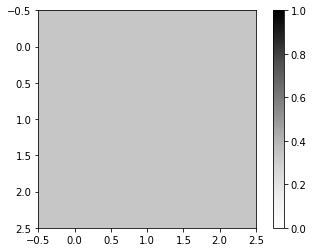

[converged] LP: -293.943:  16%|█▌        | 16/100 [00:00<00:03, 23.82it/s]


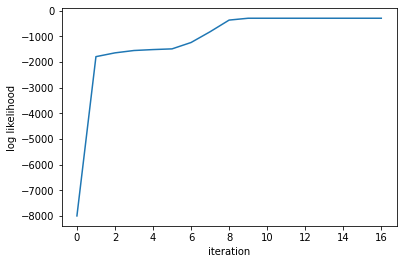

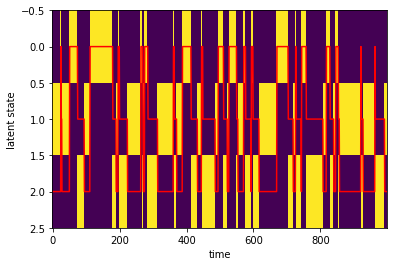

After training...
[[-0.02985493  0.9822095 ]
 [ 4.008261    4.9993696 ]
 [ 1.9918952   2.9981928 ]]


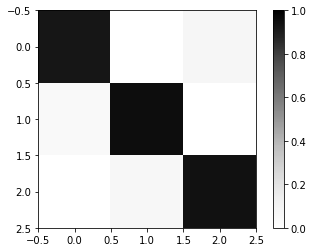

In [24]:
# Gaussian example
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2))
true_hmm = GaussianHMM(3, 2,
                       transition_matrix=transition_matrix,
                       emission_means=emission_means,
                       emission_scale_trils=0.25 * np.eye(2))
states, data = true_hmm.sample(jr.PRNGKey(1), 1000)

test_hmm = GaussianHMM.initialize(jr.PRNGKey(2), 3, data)
print("Before training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

lps, test_hmm, posterior = em(test_hmm, data, m_step_type="exact", num_iters=100)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

# Posterior distribution
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, 'r-')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()

print("After training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

Before training...
[[ 2.0216699   2.8641508 ]
 [ 2.3312087   3.1740606 ]
 [-0.21046019  0.9305372 ]]


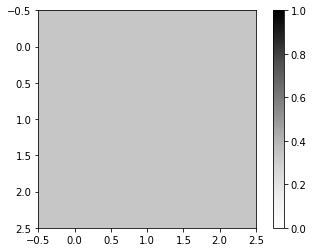

LP: -371.413: 100%|██████████| 10000/10000 [00:59<00:00, 168.00it/s]


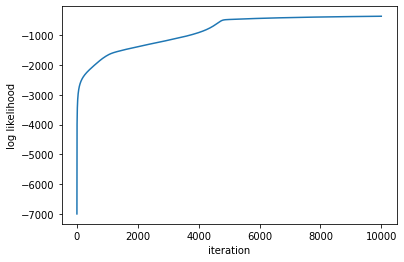

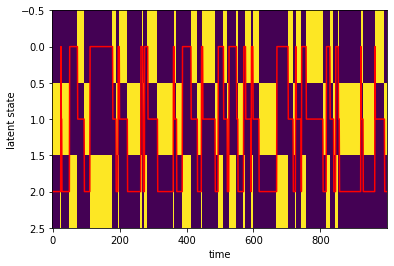

After training...
[[ 1.9918712   2.9981456 ]
 [ 4.0081854   4.999309  ]
 [-0.02985579  0.98219585]]


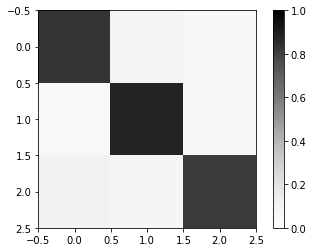

In [25]:
# Gaussian example
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2))
true_hmm = GaussianHMM(3, 2,
                       transition_matrix=transition_matrix,
                       emission_means=emission_means,
                       emission_scale_trils=0.25 * np.eye(2))
states, data = true_hmm.sample(jr.PRNGKey(1), 1000)  # compare to 0

test_hmm = GaussianHMM.initialize(jr.PRNGKey(90), 3, data)
print("Before training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

lps, test_hmm, posterior = em(test_hmm, data, m_step_type="sgd_marginal_likelihood", num_iters=10000, num_inner=4)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

# Posterior distribution
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, 'r-')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()

print("After training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

Before training...
[[ 2.0216699   2.8641508 ]
 [ 2.3312087   3.1740606 ]
 [-0.21046019  0.9305372 ]]


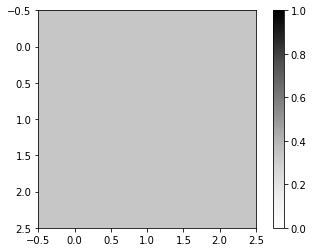

[converged] LP: -293.943:  11%|█         | 1051/10000 [00:07<01:01, 146.16it/s]


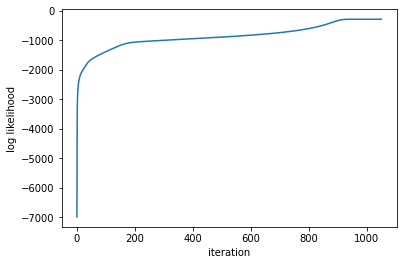

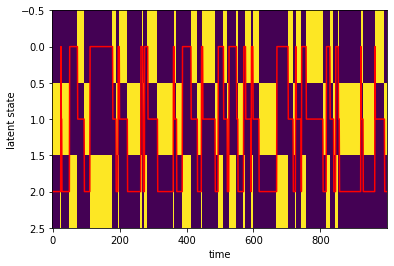

After training...
[[ 1.9918905   2.9981833 ]
 [ 4.0082464   4.999358  ]
 [-0.02985495  0.9822068 ]]


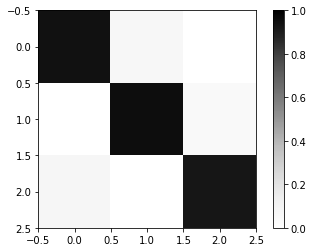

In [26]:
# Gaussian example
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2))
true_hmm = GaussianHMM(3, 2,
                       transition_matrix=transition_matrix,
                       emission_means=emission_means,
                       emission_scale_trils=0.25 * np.eye(2))
states, data = true_hmm.sample(jr.PRNGKey(1), 1000)  # compare to 0

test_hmm = GaussianHMM.initialize(jr.PRNGKey(90), 3, data)
print("Before training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

lps, test_hmm, posterior = em(test_hmm, data, m_step_type="sgd_expected_log_prob", num_iters=10000, num_inner=4)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

# Posterior distribution
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, 'r-')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()

print("After training...")
print(test_hmm.emission_means)
plt.imshow(test_hmm.transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.colorbar()
plt.show()

### Poisson Example

In [27]:
# Poisson example
transition_matrix = 0.95 * np.eye(3) + 0.05 * np.roll(np.eye(3), 1, axis=1)
emission_rates = np.arange(1, 31, dtype=np.float32).reshape((3, 10))
true_hmm = PoissonHMM(3, 10,
                      transition_matrix=transition_matrix,
                      emission_rates=emission_rates)
states, data = true_hmm.sample(jr.PRNGKey(0), 1000)

[converged] LP: -27368.781:  10%|█         | 10/100 [00:00<00:05, 17.73it/s]


estimated rates
[[20.674623   21.913855   22.52871    24.055017   25.485584   25.720062
  27.363605   27.947327   28.810974   30.124384  ]
 [10.598134   12.033725   13.318979   13.9202     15.168738   16.22699
  17.092014   18.25154    19.162569   19.941692  ]
 [ 0.97656244  1.9882811   3.0859375   3.7382812   5.0664062   6.0546875
   6.7421875   8.273437    8.8203125  10.027344  ]]


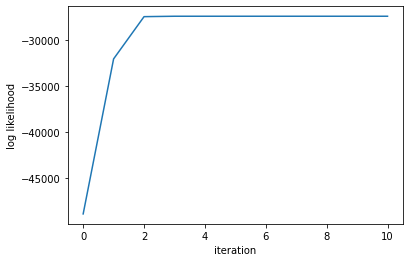

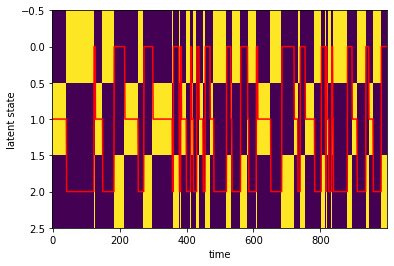

In [28]:
test_hmm = PoissonHMM.initialize(jr.PRNGKey(1), 3, data)
lps, test_hmm, posterior = em(test_hmm, data, m_step_type="exact", num_iters=100)
print("estimated rates")
print(test_hmm.emission_rates)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Posterior distribution
plt.figure()
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, '-r')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()

LP: -28792.336: 100%|██████████| 10000/10000 [00:32<00:00, 310.97it/s]


estimated rates
[[20.674175  21.913391  22.528275  24.054571  25.485207  25.71962
  27.363174  27.94688   28.810646  30.12386  ]
 [10.6777115 12.087694  13.348713  13.951117  15.196777  16.242512
  17.109608  18.262993  19.17212   19.952122 ]
 [ 3.4153376  4.0648484  4.8101907  5.279139   6.2615976  7.057114
   7.617015   8.911141   9.4052305 10.471685 ]]


Text(0, 0.5, 'latent state')

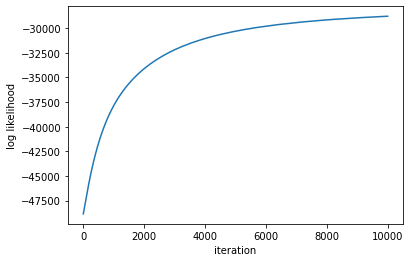

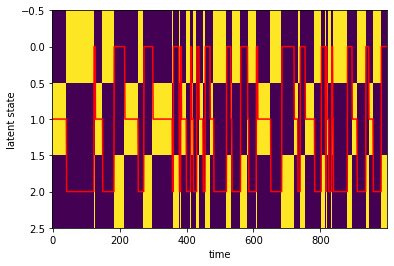

In [29]:
test_hmm = PoissonHMM.initialize(jr.PRNGKey(1), 3, data)
lps, test_hmm, posterior = em(test_hmm, data, m_step_type="sgd_marginal_likelihood", num_iters=10000)
print("estimated rates")
print(test_hmm.emission_rates)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Posterior distribution
plt.figure()
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, '-r')
plt.xlabel("time")
plt.ylabel("latent state")

LP: -27382.857: 100%|██████████| 10000/10000 [00:31<00:00, 318.91it/s]


estimated rates
[[20.676449  21.915678  22.530535  24.056847  25.48742   25.72189
  27.365433  27.94916   28.812809  30.126215 ]
 [10.60193   12.037521  13.322778  13.923998  15.172536  16.230785
  17.095814  18.25533   19.166367  19.945488 ]
 [ 1.3269997  2.1334388  3.1370502  3.7657545  5.0756507  6.0603256
   6.746912   8.278275   8.825149  10.032179 ]]


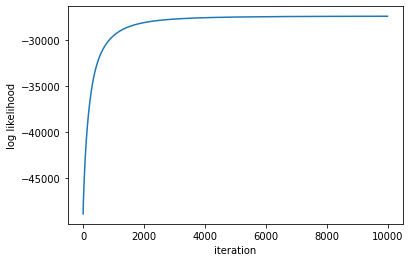

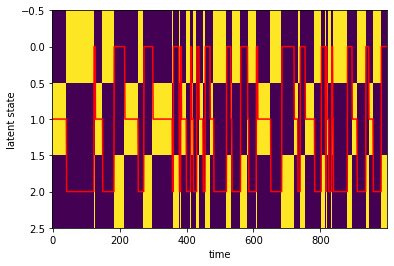

In [30]:
test_hmm = PoissonHMM.initialize(jr.PRNGKey(1), 3, data)
lps, test_hmm, posterior = em(test_hmm, data, m_step_type="sgd_expected_log_prob", num_iters=10000)
print("estimated rates")
print(test_hmm.emission_rates)

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Posterior distribution
plt.figure()
plt.imshow(posterior.expected_states.T, aspect="auto", interpolation="none")
plt.plot(states, '-r')
plt.xlabel("time")
plt.ylabel("latent state")
plt.show()